In [1]:
!pip install -U tensorflow==2.12
!pip install -U keras==2.12

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 104.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input

from keras.applications import VGG19, EfficientNetB1, EfficientNetB5, Xception, MobileNetV3Large, ConvNeXtBase 


from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt


import glob
import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Tensorflow version 2.12.0
Keras version 2.12.0


In [46]:
# data path


epochs = 5001

# batch size equals to 8 (due to RAM limits)
batch_size = 11

# define the shape of low resolution image (LR) 
low_resolution_shape =  (800, 1200, 3) #(64, 64, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (800, 1200, 3) #(256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 96
tf.random.set_seed(SEED)
SHAPE = (1200, 800)

## Data

In [47]:

low = glob.glob('/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/*')
high = glob.glob('/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res/*')

In [48]:

def find_img_dims(image_list):
    
    size_1 = [] 
    size_2 = []
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        size_1.append((im.size[0]))
        size_2.append((im.size[1]))
        #print(im.size)
    max_1 = np.max(size_1)
    max_2 = np.max(size_2)
    min_1 = np.min(size_1)
    min_2 = np.min(size_2)
    
    return (max_1, max_2), (min_1, min_2)

In [49]:
find_img_dims(low)

((1200, 800), (1196, 797))

In [50]:
find_img_dims(high)

((1200, 800), (1196, 797))

In [10]:
len(low), len(high)

(3762, 1254)

# Until not fixed use 11 Bach size

## IV. Utility functions

Quantitative metrics for image quality  
Loss functions  
Plots  
Image processing: sampling and saving images

### IV A. Metrics

#### 1. PSNR - Peak Signal-to-Noise ratio


PSNR is the ratio between maximum possible power of signal and power of corrupting noise (Wikipedia). 


$${ PSNR = 10  \log_{10}  \left( {MAX_I^2 \over MSE} \right) }$$

$ MAX_I $  -  maximum possible power of a signal of image I  
$ MSE $  -  mean squared error pixel by pixel 

In [51]:
def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val=1.0)

    return tf.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

In [52]:
def plot_psnr(psnr):
    
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means)    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR') 
    plt.title('PSNR')

#### 2. SSIM - Structural Similarity Index


SSIM measures the perceptual difference between two similar images [(see Wikipedia)](https://en.wikipedia.org/wiki/Structural_similarity).

$${ SSIM(x, y) = {(2 \mu_x \mu_y + c_1) (2 \sigma_{xy} + c_2) \over (\mu_x^2 + \mu_y^2 + c_1) ( \sigma_x^2 + \sigma_y^2 +c_2)}  }$$


$ \mu_x, \mu_y$       - average value for image $x, y$    
$ \sigma_x, \sigma_y$ - standard deviation for image $x, y$     
$ \sigma_{xy}$        - covariance  of $x$ and $y$      
$ c_1, c_2 $          - coefficients 

In [54]:
def compute_ssim(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return tf.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

In [53]:
def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']

    plt.figure(figsize=(10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')

### IV B. Loss Functions

The most important contribution of the SRGAN paper was the use of a *perceptual loss* function. 


**Perceptual Loss**  is a weighted sum of the *content loss* and *adversarial loss*.


$${ l^{SR} = l_X^{SR} + 10^{-3}l_{Gen}^{SR}}$$

$l^{SR}$ - perceptual loss   
$l_X^{SR}$ - content loss   
$l_{Gen}^{SR}$ - adversarial loss 


****************************

**1. Content Loss**   
The SRGAN replaced the *MSE loss* with a *VGG loss*. Both losses are defined below: 

         
**Pixel-wise MSE loss** is the mean squared error between each pixel in the original HR image and a the corresponding pixel in the generated SR image.


**VGG loss** is the euclidean distance between the feature maps of the generated SR image and the original HR  image. The feature maps are the activation layers of the pre-trained  VGG 19 network. 

$${ l_{{VGG}/{i,j}}^{SR} = {1 \over {W_{i,j}H_{i,j}}} \sum\limits_{x=1}^{W_{i,j}} \sum\limits_{y=1}^{H_{i,j}}  ({\phi}_{i,j}(I^{HR})_{x,y} - {\phi}_{i,j} (G_{{\theta}_G} (I^{LR}))_{x,y})^2}$$


$ l_{{VGG}/{i,j}}^{SR} $  -  VGG loss    
$ {\phi}_{i,j} $  -   the feature map obtained by the j-th convolution (after activation) before the i-th maxpooling layer within the VGG19 network



**2. Adversarial Loss**  
This is calculated based on probabilities provided by Discriminator.

$${ l_{Gen}^{SR} = \sum\limits_{n=1}^{N} - \log{D_{{\theta}_D}} (G_{{\theta}_G} (I^{LR}))}$$

$ l_{Gen}^{SR} $  -  generative loss  
$ D $  -  discriminator function    
$ D_{{\theta}_D} $  -  discriminator function parametrized with $ {\theta}_D $   
$ {D_{{\theta}_D}} (G_{{\theta}_G} (I^{LR})) $   -  probability that the reconstructed image $ 
$ G_{{\theta}_G} (I^{LR}) $  is a natural HR image

#### Plot loss function

In [55]:
def plot_loss(losses):

    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
   
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss")    
    plt.legend()

### IV C. Sampling, saving images

In [23]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    

In [78]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    path_low = '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res'
    path_high = '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res'

    images_batch_lr = []
    images_batch_hr = []

    im_n = ['_2','_4','_6']
     
    for el in images_batch:
        el = el.split('.')[0]
        el = el + np.random.choice(im_n, 1)[0]
        
        images_batch_lr.append(path_low+'/'+el+'.jpg')


    for el in images_batch:
        images_batch_hr.append(path_high+'/'+el)


    #print(images_batch_hr, images_batch_lr)

    for hr, lr in zip(images_batch_hr, images_batch_lr):
  
        hr1 = imread(hr, pilmode='RGB', )
        hr1 = cv2.resize(hr1, high_resolution_shape[1:] )
        #img1 = imread(img, pilmode='RGB')
        hr1 = hr1.astype(np.float32)

        lr1 = imread(lr, pilmode='RGB')
        lr1 = cv2.resize(lr1, high_resolution_shape[1:] )
        #img1 = imread(img, pilmode='RGB')
        lr1 = lr1.astype(np.float32)
        
        # change the size     
        hr1_high_resolution = imresize(hr1, high_resolution_shape)
        lr1_low_resolution = imresize(lr1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            hr1_high_resolution = np.fliplr(hr1_high_resolution)
            lr1_low_resolution = np.fliplr(lr1_low_resolution)
       
        hr_images.append(hr1_high_resolution)
        lr_images.append(lr1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    

In [76]:
import cv2

In [57]:
im_n = ['_2','_4','_6']
np.random.choice(im_n, 1)[0]

'_4'

In [58]:
high_2 = []
for si in high:
    high_2.append(si.split('/')[6])


In [59]:
def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','SR - generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)    

In [60]:
SHAPE = (1200, 800)

## V. SRGAN-VGG19

The SRGAN has the following code components:
 1. Generator network
 2.  Discriminator network
 3. Feature extractor using the VGG19 network
 4. Adversarial framework

### V 1. Generator

There are 16 residual blocks and 2 upsampling blocks. The generator follows the architecture outlined in [2]. 

In [61]:
def residual_block(x, paddings, kernel_size = 3, strides = 1, filters = (64, 64),):

    momentum = 0.8
    activation = "relu"


    res = Conv2D( filters=filters[0], kernel_size=kernel_size, strides=strides)(x) #padding=padding
    res =  tf.pad(res, paddings, mode='REFLECT', constant_values=0, name='mirror')
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides)(res)  #padding=padding
    res =  tf.pad(res, paddings, mode='REFLECT', constant_values=0, name='mirror')
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)


    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, )(res)  #padding=padding
    res =  tf.pad(res, paddings, mode='REFLECT', constant_values=0, name='mirror')
    res = BatchNormalization(momentum=momentum)(res)


    res = Conv2D(filters=filters[1]/2, kernel_size=1, strides=strides, )(res)
    #res.s
    #x = tf.keras.layers.Cropping2D()
    res = Add()([res, x])


    
    
    return res

In [ ]:
SHAPE = (1200, 800)

In [62]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    paddings_3 = tf.constant([[1,1],[1,1], [1,1],[0,0]])
    paddings_5 = tf.constant([[2,2],[2,2], [2,2],[0,0]])
    # input LR dimension: 4x downsample of HR
    input_shape = (800,  1200, 3)
    
    # input for the generator
    input_layer = Input(input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=32, kernel_size=3, strides=1, activation='relu')(input_layer)
    gen1 =  tf.pad(gen1, paddings_3, mode='REFLECT', constant_values=0, name='mirror')
    
    # add 16 residual blocks
    #res = residual_block(gen1)
    for i in range(2 - 1):
        res = residual_block(gen1, paddings_3, kernel_size = 3, strides = 1, filters = (32, 64) )


    res = residual_block(res, paddings_5, kernel_size = 5, strides = 1, filters = (32, 64))
    res = residual_block(res, paddings_3, kernel_size = 3, strides = 1, filters = [32, 64])

    for i in range(3 - 1):
        res = residual_block(res, paddings_5, kernel_size = 5, strides = 1, filters = [32, 64] )
        #1dconv
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(res)
    
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=5, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=7, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6) #silu
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model



In [63]:

generator = build_generator()


In [89]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

In [96]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (800, 1200, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

In [97]:


generator = build_generator()



### V 2. Discriminator

In [98]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (800,  1200, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)   
    
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

In [99]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

### V 3. EFB1 Feature Extractor 

In [100]:

efb1 = EfficientNetB1(input_shape=(800,  1200, 3), include_top=False, weights='imagenet')

extractor = Model(inputs=efb1.inputs, outputs=efb1.get_layer('block5a_project_conv').output)
#features = extractor.predict(x)

In [101]:
def build_VGG19():
    
    input_shape = (800,  1200, 3)
    efb1.outputs = [efb1.get_layer('').output]
    input_layer = Input(shape=input_shape)
    features = efb1(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    
    return model

In [102]:
low_resolution_shape = (800,  1200, 3)
high_resolution_shape = low_resolution_shape

In [103]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model


In [104]:
adversarial_model = build_adversarial_model(generator, discriminator, extractor)

## VI. Training 


In [71]:
# initialize 

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

In [32]:
from glob import glob

def get_train_images(path):
    
    #image_list = glob('../input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/*')
    image_list = sorted(glob(path))
    return image_list

In [58]:
h = get_train_images('/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res/*')
l = get_train_images('/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/*')
hl_tot = []
for i in zip(h,l):
    hl_tot.append(i)

In [33]:
hr_images, lr_images = sample_images(high_2, 
                                         batch_size=11,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)

In [34]:
hr_images.shape

(11, 800, 1200, 3)

In [35]:
lr_images.shape

(11, 800, 1200, 3)

In [87]:
batch_size=2

In [84]:
high_2 = high_2[:4]

In [86]:
high_2 = ['1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg','1005.jpg']

In [ ]:
# training loop

for epoch in range(epochs):

    d_history = []
    g_history = []
    
    #image_list = get_train_images()
    
    """
    Train the discriminator network
    """
    
    hr_images, lr_images = sample_images(high_2, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(high_2, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)


    
    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images],
                                               [real_labels, image_features])
    
    losses['g_history'].append(0.5 * (g_loss[1]))
    
    
    
    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)

    
  
    """
        save and print image samples
    """
    
    if epoch % 500 == 0:
        
        hr_images, lr_images = sample_images(high_2, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 3:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="/kaggle/working/img_{}_{}".format(epoch, index))  

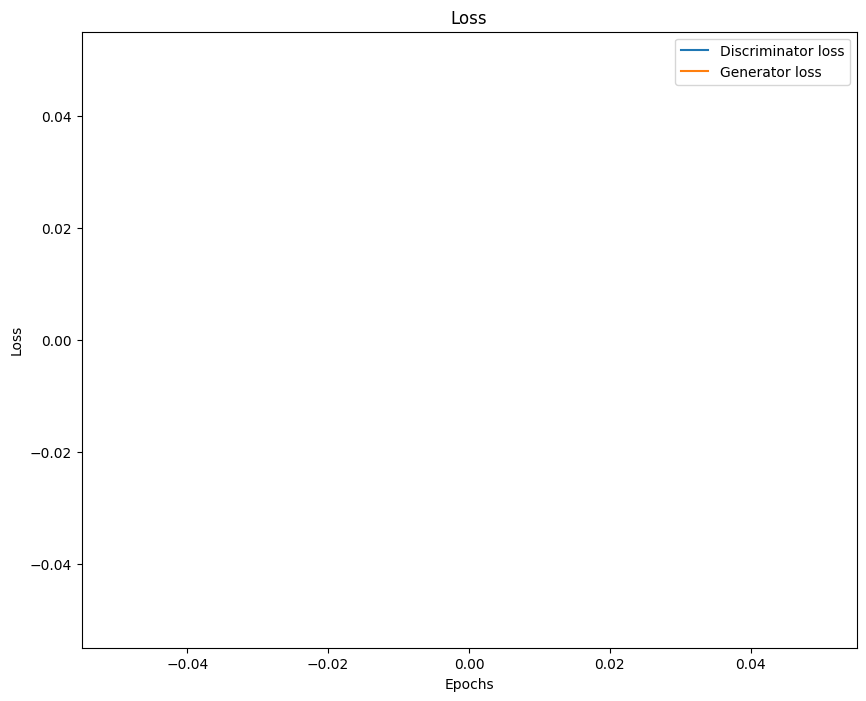

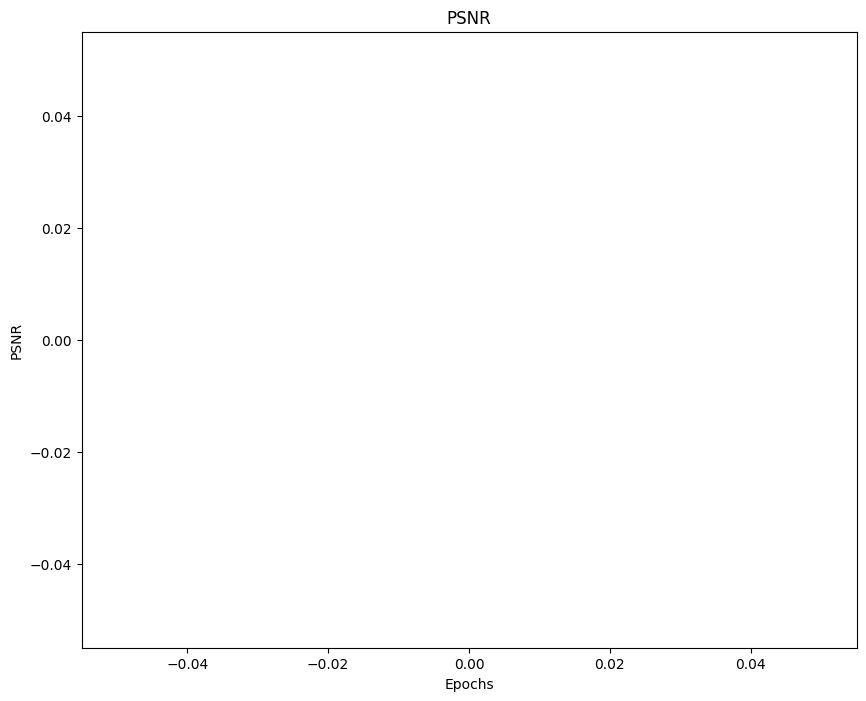

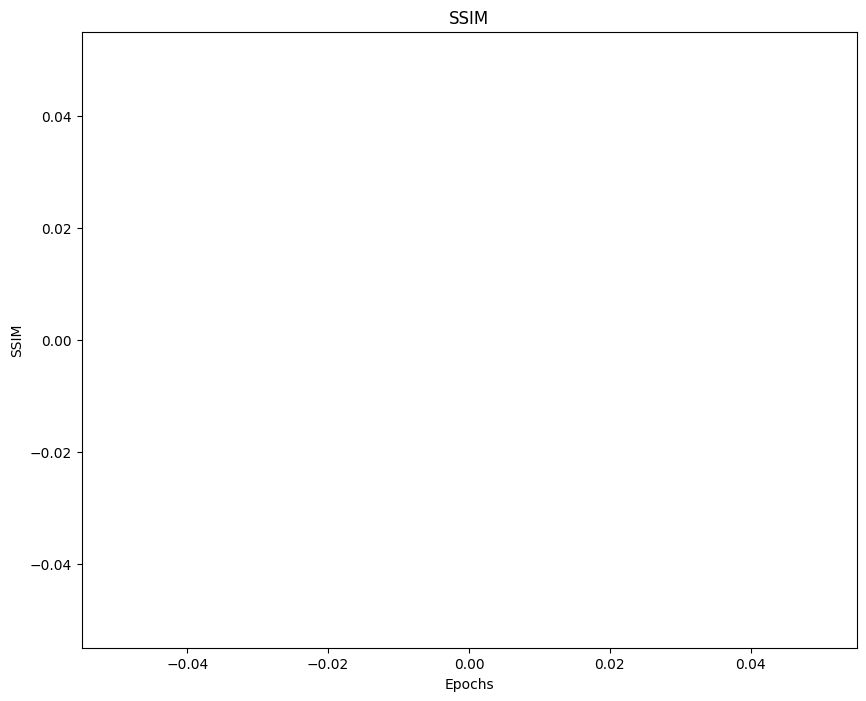

In [85]:
# plots - post training

plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)

In [ ]:
# save model weights

generator.save_weights("/kaggle/working/srgan_generator.h5")
discriminator.save_weights("/kaggle/working/srgan_discriminator.h5")

## VII. References and further reading


<a name="ref1"></a>[1] [Goodfellow et al. 'Generative Adversarial Nets'](https://arxiv.org/pdf/1406.2661.pdf)

<a name="ref2"></a>[2] [Ledig et al. 'Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network'](https://arxiv.org/abs/1609.04802)

<a name="ref3"></a>[3] [Kailash Ahirwar. 'Generative Adversarial Networks Projects'](https://github.com/PacktPublishing/Generative-Adversarial-Networks-Projects)

<a name="ref4"></a>[4] [Saeed Anwar et al. 'A Deep Journey into Super-resolution: A Survey'](https://arxiv.org/pdf/1904.07523.pdf)

<a name="ref5"></a>[5] [Xintao Wang et al. 'ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks'](https://arxiv.org/pdf/1809.00219.pdf)